In [ ]:
'''
PPCA 5.0 RESIDENTIAL & NON-RESIDENTIAL BUILDINGS : FILL NULL VALUES WITH MACHINE LEARNING

Author : Perez, Joan

XXX

Requirements:
- A specific working environment (see README on the github page of the project https://github.com/perezjoan/PPCA-codes?tab=readme-ov-file)
- Output file from PPCA 4.0 ('osm_all_buildings_res_type_with_null' (Polygon), OSM all buildings)

Guide to run the script:
- Fill 0.2 box

Output :
- A geopackage file with a single layer
    * 'osm_all_buildings_res_type_with_null' (Polygon), osm buildings with residential classification

Acknowledgement: This resource was produced within the emc2 project, which is funded by ANR (France), FFG (Austria), MUR (Italy) and 
Vinnova (Sweden) under the Driving Urban Transition Partnership, which has been co-funded by the European Commission.

License: Attribution-ShareAlike 4.0 International - CC-BY-SA-4.0 license
'''

In [1]:
# 0.1 : libraries
import pandas as pd
import numpy as np
import geopandas as gpd
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [2]:
# 0.2 : Box to fil with informations

# Name of the case study
Name = 'Nice'

In [3]:
# 1. DATA PREPARATION & SUBSET DATA INTO TRAIN AND TEST DATA 0.7 / 0.3

gpkg = f'PPCA4_{Name}.gpkg'
building = gpd.read_file(gpkg, layer='osm_all_buildings_res_type_with_null')

# List of columns to keep
columns_to_keep = ['FL', 'A', 'P', 'E', 'C', 'FA', 'ECA', 'EA', 'SW', 'type']

# Subset the DataFrame
building_filtered = building[columns_to_keep]

# Subset the data where 'type' is 1 or 2
building_res = building_filtered[building_filtered['type'].isin([1, 2])]

# Subset the data where 'type' is 0
building_null = building_filtered[building_filtered['type'] == 0]

# Set a random seed for reproducibility
np.random.seed(45)

# Create a boolean mask for selecting 70% of the data for training
mask = np.random.rand(len(building_res)) < 0.7

# Split the data into training and testing sets
data_train = building_res[mask]
data_test = building_res[~mask]

# Display the shapes of the resulting datasets
print(f"Training data shape: {data_train.shape}")
print(f"Testing data shape: {data_test.shape}")

Training data shape: (8233, 10)
Testing data shape: (3518, 10)


In [4]:
# 2. CALCULATE DECISION TREE CLASSIFIER & PRINT PRECISION

# Initialize the Decision Tree Classifier
np.random.seed(45)
clf = DecisionTreeClassifier()

# Separate the target variable and features for the training set
X_train = data_train.drop(columns=['type'])
y_train = data_train['type']

# Train the classifier
clf.fit(X_train, y_train)

# Separate the features and target variable for the test set
X_test = data_test.drop(columns=['type'])
y_test = data_test['type']

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test data: {accuracy:.2f}")

# Apply the model to building_null
# Ensure that we are using the same features as those used during training
X_null = building_null.drop(columns=['type'])

# Make sure there are no additional columns
X_null = X_null[X_train.columns]

# Predict the types for building_null
building_null.loc[:, 'type'] = clf.predict(X_null)

Accuracy on test data: 0.77


In [5]:
# 3. APPLY THE TREE TO THE NULL VALUES
X_null = building_filtered.drop(columns=['type'])

# Predict the types for building_null
building_filtered = building_filtered.copy()  # Ensure we are working on a copy
building_filtered.loc[:, 'type_pred'] = clf.predict(X_null)

# Keep only one column from building_filtered
type_pred = building_filtered[['type_pred']]

# Concatenate along columns
building_final = pd.concat([building.reset_index(drop=True), type_pred.reset_index(drop=True)], axis=1)

# Create the 'type_filled' column which take the non null values of building type, otherwise fill the null values with the model predictions
building_final['type_filled'] = np.where(building_final['type'].isin([1, 2]), 
                                         building_final['type'], 
                                         building_final['type_pred'])

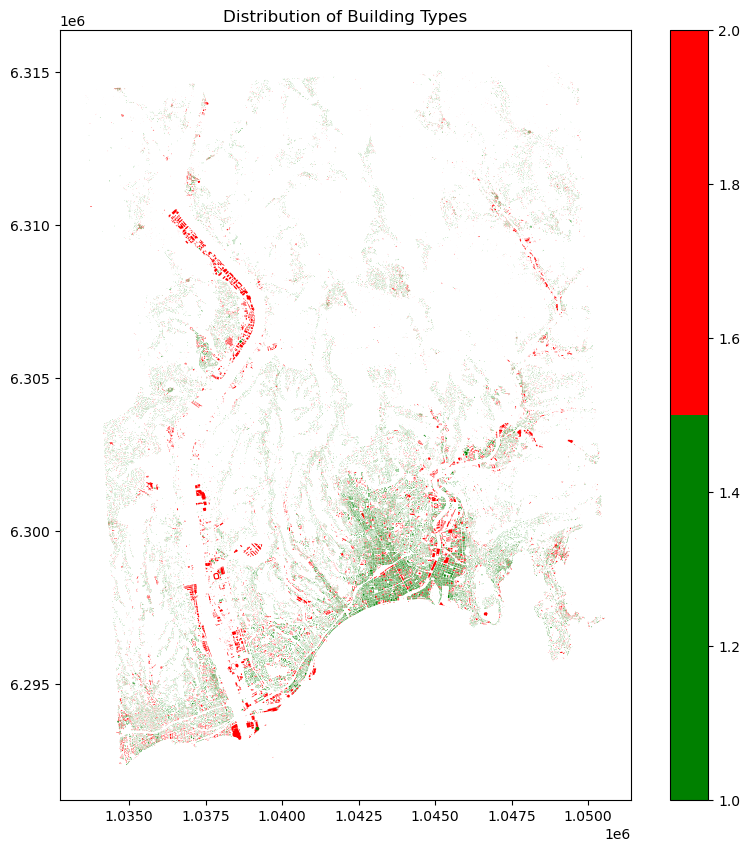

In [6]:
# Define custom colors
colors = ['green', 'red']

# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))
building_final.plot(column='type_filled', legend=True, ax=ax, cmap=ListedColormap(colors))

# Add a title
plt.title('Distribution of Building Types')

# Show the plot
plt.show()

|--- FL <= 1.50
|   |--- A <= 49.71
|   |   |--- FA <= 31.97
|   |   |   |--- SW <= 0.27
|   |   |   |   |--- A <= 41.32
|   |   |   |   |   |--- FA <= 21.64
|   |   |   |   |   |   |--- E <= 0.44
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- E >  0.44
|   |   |   |   |   |   |   |--- P <= 23.29
|   |   |   |   |   |   |   |   |--- E <= 0.72
|   |   |   |   |   |   |   |   |   |--- P <= 17.69
|   |   |   |   |   |   |   |   |   |   |--- ECA <= 6.15
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |   |--- ECA >  6.15
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |--- P >  17.69
|   |   |   |   |   |   |   |   |   |   |--- FA <= 20.12
|   |   |   |   |   |   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |   |   |   |   |   |--- FA >  20.12
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   | 

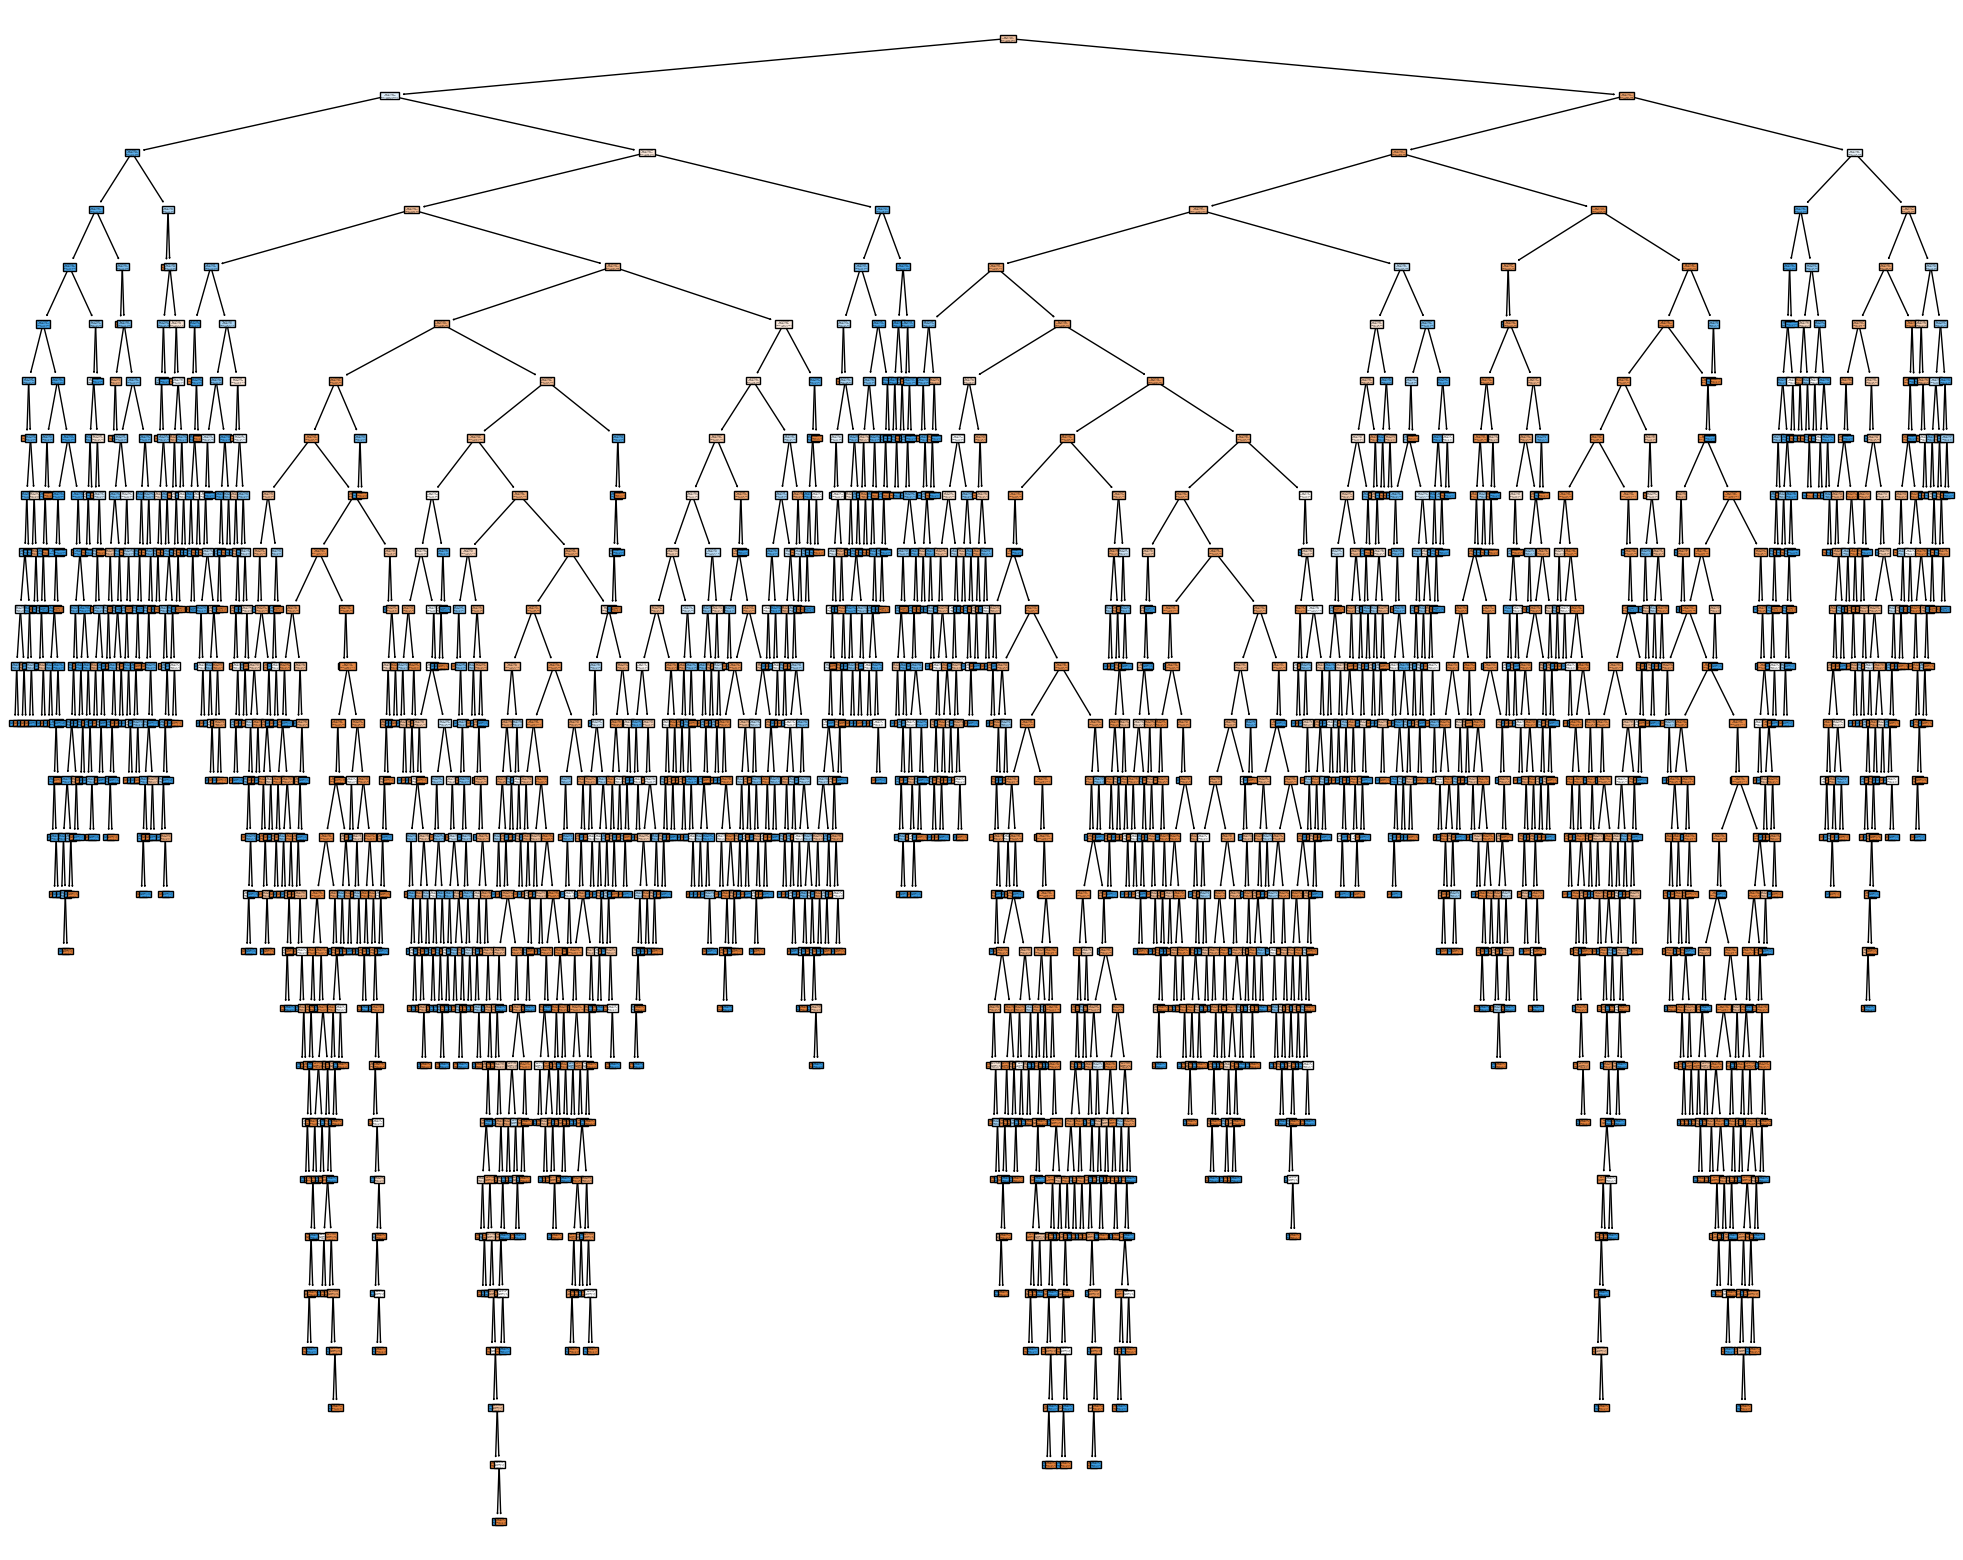

In [7]:
# A1. TREE VISUALIZATION
# Print the decision tree
text_representation = tree.export_text(clf, feature_names=list(X_train.columns))
print(text_representation)

# Optionally, visualize the decision tree (requires matplotlib)
fig = plt.figure(figsize=(25, 20))
_ = tree.plot_tree(clf, 
                   feature_names=X_train.columns,  
                   class_names=['0', '1'],
                   filled=True)
plt.show()

Accuracy on test data (proportion 0.01): 0.68
Accuracy on test data (proportion 0.02): 0.74
Accuracy on test data (proportion 0.03): 0.74
Accuracy on test data (proportion 0.04): 0.74
Accuracy on test data (proportion 0.05): 0.74
Accuracy on test data (proportion 0.060000000000000005): 0.74
Accuracy on test data (proportion 0.06999999999999999): 0.75
Accuracy on test data (proportion 0.08): 0.75
Accuracy on test data (proportion 0.09): 0.75
Accuracy on test data (proportion 0.09999999999999999): 0.76
Accuracy on test data (proportion 0.11): 0.75
Accuracy on test data (proportion 0.12): 0.76
Accuracy on test data (proportion 0.13): 0.76
Accuracy on test data (proportion 0.14): 0.76
Accuracy on test data (proportion 0.15000000000000002): 0.76
Accuracy on test data (proportion 0.16): 0.75
Accuracy on test data (proportion 0.17): 0.75
Accuracy on test data (proportion 0.18000000000000002): 0.76
Accuracy on test data (proportion 0.19): 0.75
Accuracy on test data (proportion 0.2): 0.75
Accur

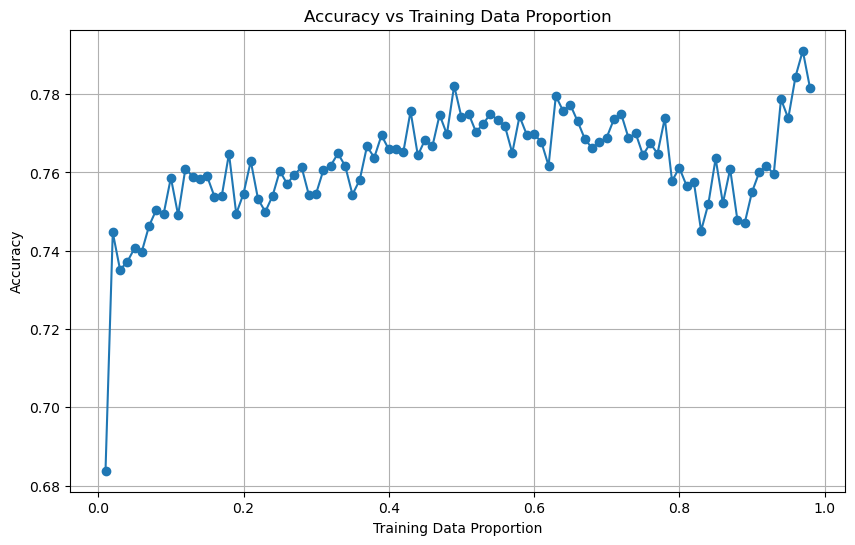

In [8]:
# A2. COMPUTE ACCURACY BASED ON TRAINING DATA SIZE
# Define the proportions for training data
train_proportions = np.arange(0.01, 0.99, 0.01)

# Lists to store proportions and corresponding accuracies
proportions_list = []
accuracies_list = []

# Loop over each training proportion
for proportion in train_proportions:
    # Set a random seed for reproducibility
    np.random.seed(45)

    # Create a boolean mask for selecting the proportion of the data for training
    mask = np.random.rand(len(building_res)) < proportion

    # Split the data into training and testing sets
    data_train = building_res[mask]
    data_test = building_res[~mask]

    # Initialize the Decision Tree Classifier
    clf = DecisionTreeClassifier()

    # Separate the target variable and features for the training set
    X_train = data_train.drop(columns=['type'])
    y_train = data_train['type']

    # Train the classifier
    clf.fit(X_train, y_train)

    # Separate the features and target variable for the test set
    X_test = data_test.drop(columns=['type'])
    y_test = data_test['type']

    # Make predictions on the test set
    y_pred = clf.predict(X_test)

    # Calculate the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy on test data (proportion {proportion}): {accuracy:.2f}")

    # Store the proportion and accuracy
    proportions_list.append(proportion)
    accuracies_list.append(accuracy)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(proportions_list, accuracies_list, marker='o')
plt.title('Accuracy vs Training Data Proportion')
plt.xlabel('Training Data Proportion')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()